# Storm surges since 1900 Delfzijl, NL

This notebook analyses the storm surges registered since 1900 at Delfzijl, the Netherlands. As large parts of the Netherlands reside below sea level and so protected against the sea by dunes and dikes, it is interesting to analyse the data, grab for possible trends in more than a century and possibly predict future storm surges. <br><br>
Marker in Delfzijl's main watergate to commemorate the 1962 storm surge:![](data/marker1962surgeDZ.jpg)

## Collecting data
Delfzijl is one of the 8 Dutch coastal stations continuously measuring the sea water level. Delfzijl, a port in the furthest north-east of the Netherlands, is chosen because of its location on the estuary of the river Ems (water impoundment), the availability of long-term tidal data and, due to gas exploration, a comparatively fast sinking soil (including the sea-bottom). So far the Delfzijl station 2 times measured tides above the national alarm code red, both in the 21st century.<br><br>
Most of the data is available in public sources but not in an easy to use format. So I decided to make a simple dataset using data from mainly Rijkswaterstaat (the Dutch Directorate-General for Public Works and Water Management). Each row in this CSV file has the attributes:
1. date of storm surge
2. max registered water level above NAP (Amsterdam Ordnance Datum; approx. Mean Sea Level MSL)
3. assigned label alarm level:  
3.1 Yellow: >= 3.00 m above MSL. All Delfzijl watergates and dike openings close at >= 3.00 m  
3.2 Orange: >= 3.80 m above MSL  
3.3 Red: >= 4.75 m above MS:  
4. remark, e.g. name of storm

The publicly available data I used can be found in Rijkswaterstaat [storm surge reports](https://waterberichtgeving.rws.nl/water-en-weer/verwachtingen-water/water-en-weerverwachtingen-waternoordzee/stormvloedrapportages/stormvloedverslagen) as from 1948. Delfzijl storm surges starting from 1900 are given in some of these reports.<br>
Note that the dataset contains yellow warning levels (>= 3.00 m) from the 1950s while before only storm surges above ***border level*** 3.34 m were reported.

In [34]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().

import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns #sets up styles and gives us more plotting options
import urllib.request
import pickle
import requests
import datetime

## Read and clean data 
Remarks are not read. A few historical sea level records before 1900 are left out.

In [35]:
def columnsToDisplay():
    return ['date', 'm_above_NAP', 'warning_code']

In [36]:
def columnsRenameDict():
    return {'m_above_NAP':'meters_above_sealevel', 'warning_code':'alarm_level' }

In [37]:
def preProcessing(df):
    df.date=(pd.to_datetime(df.date, dayfirst=True)) 

In [38]:
df = pd.read_csv('data/storm-tides-Delfzijl-NL.csv', usecols=columnsToDisplay())
df.rename(columns=columnsRenameDict(), inplace=True)
preProcessing(df)
df.tail(20)
dfNew=df[df.date>='01-01-1900'].copy()

Some basic stuff on the dataset

In [39]:
dfNew.dtypes

date                     datetime64[ns]
meters_above_sealevel           float64
alarm_level                      object
dtype: object

In [40]:
print(dfNew.shape)
print('Average height (m): ', round(dfNew.meters_above_sealevel.mean(),2))

(96, 3)
Average height (m):  3.62


In [41]:
dfFourMeters=dfNew[dfNew.meters_above_sealevel >= 4.00]
dfFourMeters

,date,meters_above_sealevel,alarm_level
8,2014-10-22,4.02,O
9,2013-12-06,4.82,R
10,2013-12-06,4.25,O
13,2007-11-09,4.21,O
17,2006-11-01,4.83,R
26,1995-01-10,4.04,O
31,1994-01-28,4.25,O
53,1976-01-21,4.08,O
54,1976-01-04,4.35,O
55,1976-01-03,4.06,O


In [42]:
print(dfFourMeters.alarm_level.unique())
thisCentury=dfFourMeters[dfFourMeters.date >= '01-01-2000']
print('Since 1900', thisCentury.date.count(), 'from', dfFourMeters.date.count(), 'surges above 4.00 m in 21st century')


['O' 'R']
Since 1900 5 from 16 surges above 4.00 m in 21st century


## Exploratory data analysis
First show the storm surge frequency over the years. Remarks to the histogram:
* As high tide occurs twice a day, they are included in the count.
* As from the 1950's tides between 3.00 and 3.34 are included.

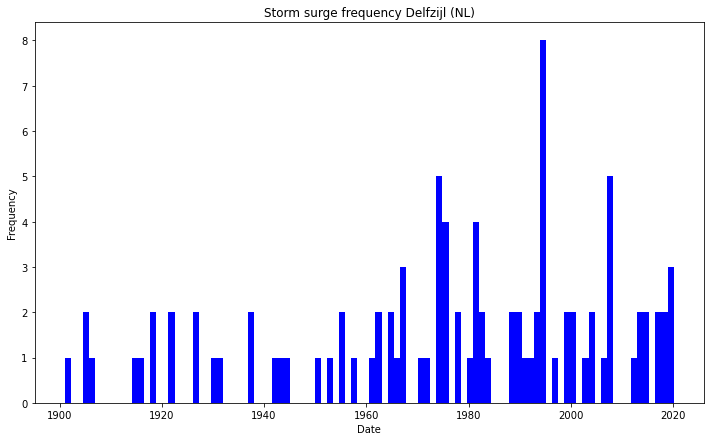

In [43]:
plt.figure(figsize=(12,7))
plt.hist(dfNew.date, bins=100, color='b')
plt.title('Storm surge frequency Delfzijl (NL)')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

Clearly storm surges do not occur each year:

In [44]:
noSurgesDZ=[]
for year in range(1900, 2021):
    if year not in set(dfNew['date'].dt.year.values):
        noSurgesDZ.append(year)
print('Years without storm surges', noSurgesDZ)

Years without storm surges [1900, 1902, 1903, 1907, 1908, 1909, 1910, 1911, 1912, 1913, 1915, 1918, 1919, 1920, 1923, 1924, 1925, 1927, 1928, 1931, 1932, 1933, 1934, 1935, 1937, 1938, 1939, 1940, 1942, 1945, 1946, 1947, 1948, 1950, 1951, 1952, 1955, 1956, 1957, 1959, 1960, 1963, 1968, 1969, 1972, 1974, 1975, 1978, 1979, 1985, 1986, 1987, 1992, 1997, 1998, 2001, 2005, 2009, 2010, 2011]


Then find out the which heights above Mean Sea Level occur most. <br><br>Note: in 2002 the storm surge barrier ***Emssperrwerk*** in the river Ems at Gandersum (Germany) was put into service. When closed it has impact on the measured water levels at Delfzijl (source: Deltares, Toets- en Rekenpeilen Kust en Estuaria ten behoeve van de HR 2011).

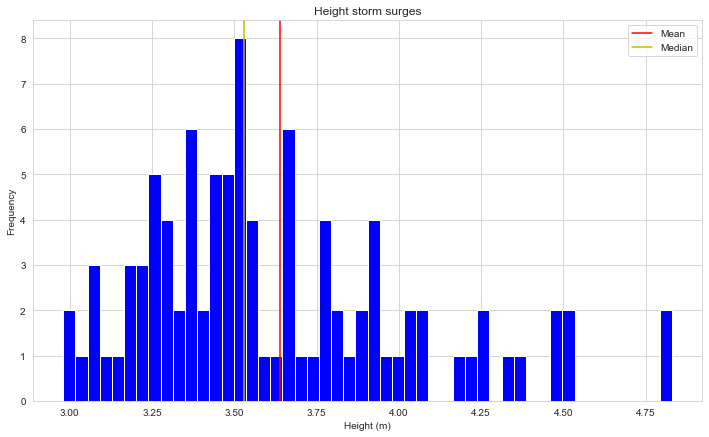

In [45]:
plt.figure(figsize=(12,7))
meanHeight=df.meters_above_sealevel.mean()
medianHeight=df.meters_above_sealevel.median()
with sns.axes_style("whitegrid"):
    plt.hist(dfNew.meters_above_sealevel, bins=50, color='b')
    plt.axvline(meanHeight, 0, 1, color='r', label='Mean')
    plt.axvline(medianHeight, 0, 1, color='y', label='Median')
    plt.title('Height storm surges')
    plt.xlabel('Height (m)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

Can we discover a storm surge season in the Delfzijl dataset? Indeed, the barplot places all storm surges symmetrically between September and April. So far summer storms have not yet been reported.

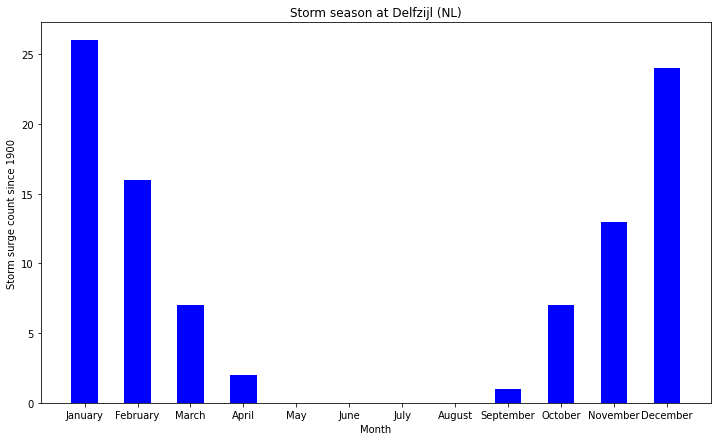

In [46]:
yearDict={'January' : 0, 'February' : 0, 'March' : 0, 'April' : 0, 'May' : 0, 'June' : 0, 'July' : 0, 'August' : 0, 'September' : 0, 'October' : 0, 'November' : 0, 'December' : 0}
season=df.groupby(dfNew['date'].dt.strftime('%B'))['meters_above_sealevel'].count()
for key, value in season.items():
    for yearKey in yearDict.keys():
        if yearKey == key:
            yearDict[key] = value
lists = yearDict.items() # return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.figure(figsize=(12,7))
plt.title('Storm season at Delfzijl (NL)')
plt.xlabel('Month')
plt.ylabel('Storm surge count since 1900')
plt.bar(x, y, width=.5, color='b')
plt.show()

Categorized storm tides since 1900. The majority of the orange labeled tides occur after the 1960s as well as the two red tides (after 2000). More warning level tides (yellow) are reported as well but that's due to the earlier not reported surges between 3.00 and 3.34.<br> The Delfzijl station measured the elsewhere devastating storm surge of 01-02-1953 with a storm tide of 3.27 which is ***below*** the 3.34 border level then in force.

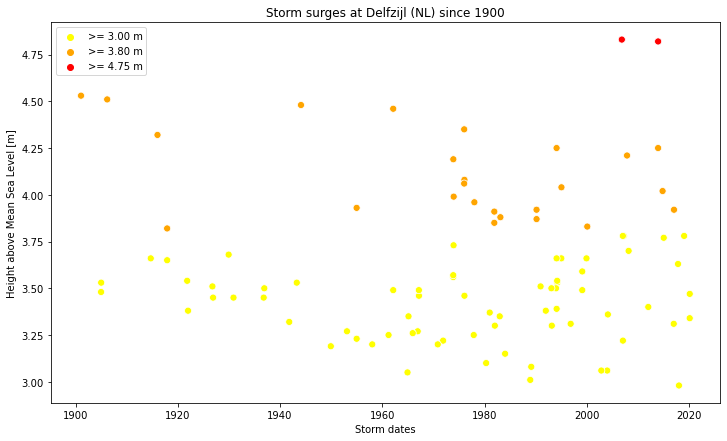

In [47]:
plt.figure(figsize=(12,7))
my_colours = ['yellow', 'orange', 'red']# Set your custom color palette
sns.set_palette(sns.color_palette(my_colours))
classes = dfNew.alarm_level.values
labels=[]
for c in classes:
    if c == 'Y':
        labels.append('>= 3.00 m')
    elif c == 'O':
        labels.append('>= 3.80 m')
    else:
        labels.append('>= 4.75 m')
sns.scatterplot(x=dfNew.date, y=dfNew.meters_above_sealevel, hue=labels, s=50)
plt.title('Storm surges at Delfzijl (NL) since 1900')
plt.ylabel('Height above Mean Sea Level [m]')
plt.xlabel('Storm dates')
plt.show()

Some initial linear regression (below) to find a trend in Delfzijl storm surges. Unexpectedly a negative relationship is plotted. Some questions arise:
* the scattering to the right (from the 1950s) is too heavy as tides up to 3.34 m are included
* no storm surge reports before 1948 are found; so might be missing points here
* should alarm levels assigned to the scattered points be taken into account?

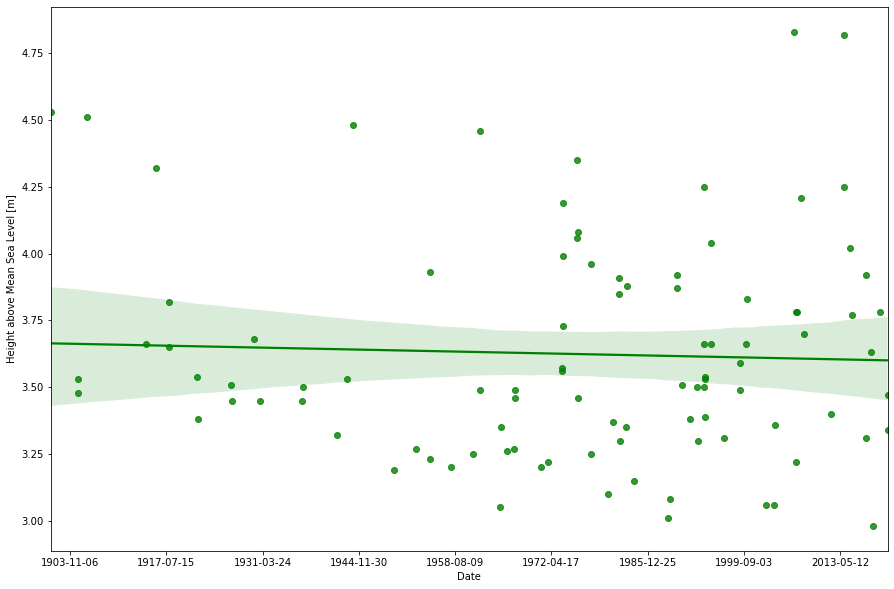

In [48]:
# to fit the linear regression line, date is converted to ordinal equivalent (experienced regplot() to have date problems)
dfNew['date_ordinal']=pd.to_datetime(dfNew['date']).apply(lambda date: date.toordinal())
plt.figure(figsize=(15,10))
ax=sns.regplot(y='meters_above_sealevel', x='date_ordinal', data=dfNew, color='g')
ax.set_xlabel('Date')
ax.set_ylabel('Height above Mean Sea Level [m]')
# reset ordinal ticks to common date format
new_labels=[datetime.date.fromordinal(int(ordinal)) for ordinal in ax.get_xticks()]
ax.set_xticklabels(new_labels)
plt.show()
#dfNew.drop(columns=['date_ordinal'])

The linear fit tends to slightly lower heights above MSL. Even regarding the confidence band this highly unlikely. The possible todo steps are:
* skip storm surges with Height above MSL < 3.34 m
* consider seperate linear regressions (per alarm level)
* possibly extend the dataset with more surges between 1900 and 1948.

### Conclusion Exploratory data analysis
* The storm surge season is between September and April
* Storm surge frequency tends to grow after the 1960s
* 75% of the surges >= 4.00 m above MSL occur in 50% (2nd half) of the measurement period (12 out of 16 surges after 1960). The 2 surges causing national alarm code red were measured this century.
* Since 2002 closing the Emssperrwerk barrier at Gandersum (Germany) during a storm surge has impact on the measured height above MSL at Delfzijl
* Storm surge heights < 3.34 above MSL must be skipped as they are not listed before 1950 

In [49]:
#skip storm surges < 3.34 m
dfNew=dfNew[dfNew.meters_above_sealevel >= 3.34]
dfNew=dfNew.reset_index(drop=True)
dfNew

,date,meters_above_sealevel,alarm_level,date_ordinal
0,2020-02-12,3.47,Y,737467
1,2020-02-10,3.34,Y,737465
2,2019-01-08,3.78,Y,737067
3,2017-10-29,3.63,Y,736631
4,2017-01-14,3.92,O,736343
...,...,...,...,...
67,1914-09-18,3.66,Y,698969
68,1906-03-13,4.51,O,695858
69,1905-01-07,3.53,Y,695428
70,1904-12-30,3.48,Y,695420


All 72 storm surges of >= 3.34 m above MSL can be plotted again to fit the linear regression line. It's just the heights we're interested in; the alarm level is a consequence of the predicted heigt. Let's see if there is no, a positive or a negative relationship.

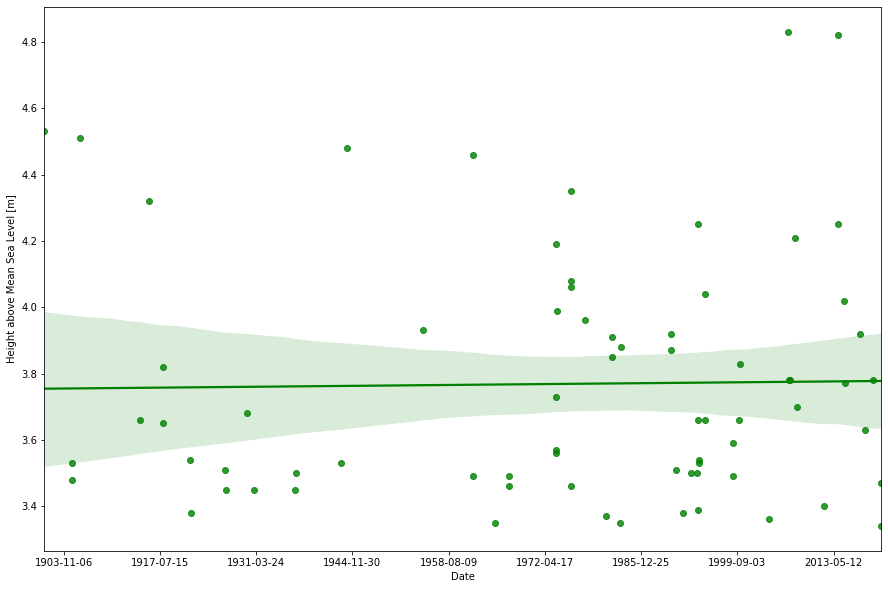

In [50]:
plt.figure(figsize=(15,10))
ax=sns.regplot(y='meters_above_sealevel', x='date_ordinal', data=dfNew, color='g')
ax.set_xlabel('Date')
ax.set_ylabel('Height above Mean Sea Level [m]')
new_labels=[datetime.date.fromordinal(int(ordinal)) for ordinal in ax.get_xticks()]
ax.set_xticklabels(new_labels)
plt.show()

As can be seen from the linear regression line above, there is a small but positive relationship: over the years an increasing storm surge height above MSL. A far steeper slope would be unrealistic. For this data science excercise this is sufficient to go for the prediction of storm surge heights.

## Predict storm surge heights
Prediction using linear regression. For the prediction of storm surge heights the simplist model of linear regression with one variable will be used: $$ Y = \beta_0 + \beta_1 X + \epsilon$$ <br>where $X$ is the independent feature (X-axis) that is linearly related to the dependent variable $Y$ (Y-axis). Constant $\beta_0$ is the intercept of the regression line, $\beta_1$ is the slope and $\epsilon$ is the error (noise) added to the linear relationship. A method called **Least Squares** is one of the most common methods to fit a linear regression model. The `statsmodels` implementation of Least Squares is applied for predicting $Y$.<br><br>
As independent variable $X$ the storm surge date will be used by means of the earlier calculated `date_ordinal`. <br> In reality many more featues will be needed to predict storm surge heights. There is hardly any correlation between storm surge date and height. As an alternative I experimented using the days between storm surges (see next cell for the calculation). However these ***waiting*** days have no correlation with the measured heights.

In [ ]:
# assign waiting days next storm surge to new column 'waiting'
daysWait=[0]
for i in range(1, dfNew.shape[0]):
    daysWait.append(abs(dfNew.date[i] - dfNew.date[i-1]).days)
dfNew['waiting']=daysWait
dfNew

### Build a linear regression to predict the next Storm Surge MSL using `statsmodels`
***

Now let's build a linear regression model for the `stormSurge` DataFrame, and estimate the next storm surge Mean Sea Level at Delfzijl if the waiting time since the last storm surge has been 400 days.

$$ StormSurgeMSL = \beta_0 + \beta_1 * Waiting + \epsilon $$ 

In [51]:
# ols - stands for Ordinary Least Squares
import statsmodels.api as sm
#X = dfNew.waiting # days to next storm surge
X = dfNew.date_ordinal
y = dfNew.meters_above_sealevel # height above MSL
model = sm.OLS(y, X)

In [52]:
results = model.fit()

In [53]:
print(results.summary())

                                  OLS Regression Results                                  
Dep. Variable:     meters_above_sealevel   R-squared (uncentered):                   0.991
Model:                               OLS   Adj. R-squared (uncentered):              0.990
Method:                    Least Squares   F-statistic:                              7425.
Date:                   Fri, 06 Nov 2020   Prob (F-statistic):                    1.38e-73
Time:                           20:16:42   Log-Likelihood:                         -30.280
No. Observations:                     72   AIC:                                      62.56
Df Residuals:                         71   BIC:                                      64.84
Df Model:                              1                                                  
Covariance Type:               nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------

In [54]:
results.params.values

array([5.22712326e-06])

We notice, there is no intercept ($\beta_0$) fit in this linear model.  To add it, we can use the function `sm.add_constant`.  

In [55]:
X = sm.add_constant(X)
X.head()

,const,date_ordinal
0,1.0,737467
1,1.0,737465
2,1.0,737067
3,1.0,736631
4,1.0,736343


Now that we have an intercept, let's fit a linear regression model again. 

In [56]:
modelWi = sm.OLS(y, X)
resultsWi = modelWi.fit()
print(resultsWi.summary())

                              OLS Regression Results                             
Dep. Variable:     meters_above_sealevel   R-squared:                       0.000
Model:                               OLS   Adj. R-squared:                 -0.014
Method:                    Least Squares   F-statistic:                   0.02365
Date:                   Fri, 06 Nov 2020   Prob (F-statistic):              0.878
Time:                           20:16:51   Log-Likelihood:                -29.360
No. Observations:                     72   AIC:                             62.72
Df Residuals:                         70   BIC:                             67.27
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3

For example, to predict the storm surge height 400 days after the last storm surge, use `results.predict`.

In [57]:
#newX = np.array([1,400])
ordinalDate=(pd.to_datetime('31-12-2021')).toordinal()
newX=np.array([1,ordinalDate]) #ordinal date
resultsWi.predict(newX)

array([3.77792668])

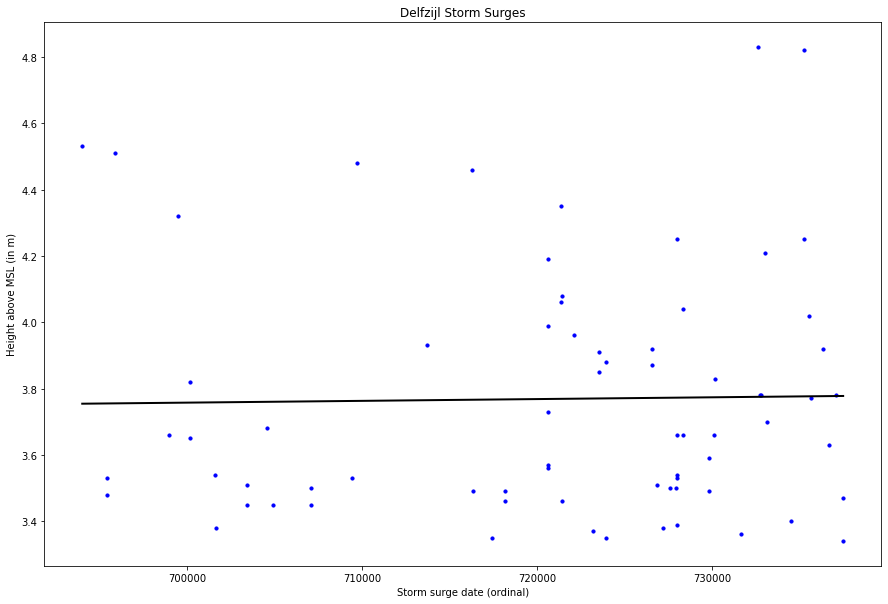

In [58]:
plt.figure(figsize=(15, 10))
#plt.scatter(dfNew.waiting, dfNew.meters_above_sealevel, s=10, c='b')
plt.scatter(dfNew.date_ordinal, dfNew.meters_above_sealevel, s=10, c='b')
plt.xlabel('Storm surge date (ordinal)')
plt.ylabel('Height above MSL (in m)')
plt.title('Delfzijl Storm Surges')
#plt.plot(dfNew.waiting, resultsWi.fittedvalues, color='black', linewidth=2)
plt.plot(dfNew.date_ordinal, resultsWi.fittedvalues, color='black', linewidth=2)
plt.show()

The expected storm surge height on 31-12-2021 is approximately 3.78m. 

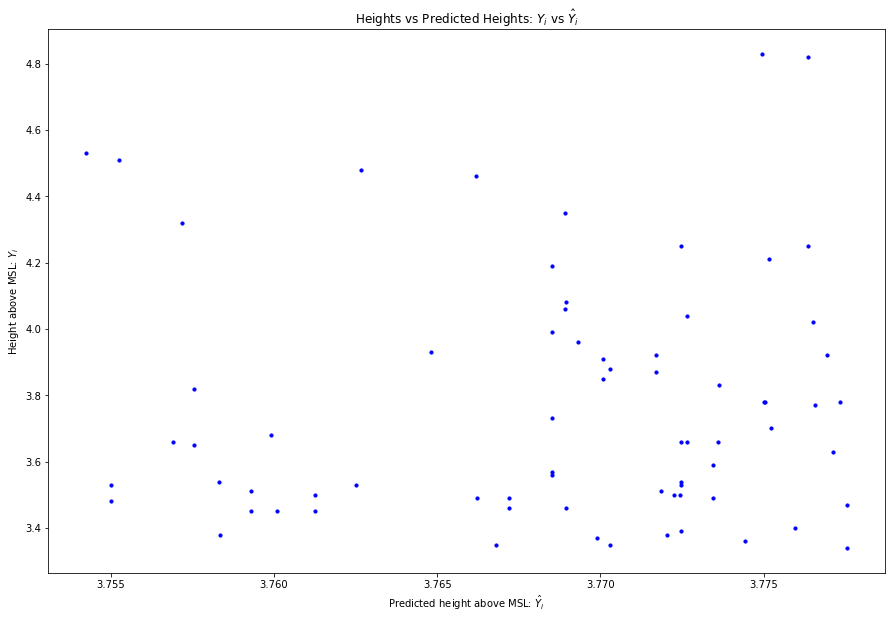

In [59]:
plt.figure(figsize=(15,10))
plt.scatter(resultsWi.fittedvalues, dfNew.meters_above_sealevel, c='b', s=10)
plt.xlabel("Predicted height above MSL: $\hat{Y}_i$")
plt.ylabel("Height above MSL: $Y_i$")
plt.title("Heights vs Predicted Heights: $Y_i$ vs $\hat{Y}_i$")
plt.show()

### Residuals
Or how well a line fits an individual data point. Residuals are vertical lines between regression line and points; positive if above the regression line and negative if below. In other words: observed value - predicted value.

In [60]:
residuals = dfNew.meters_above_sealevel - resultsWi.predict(X)

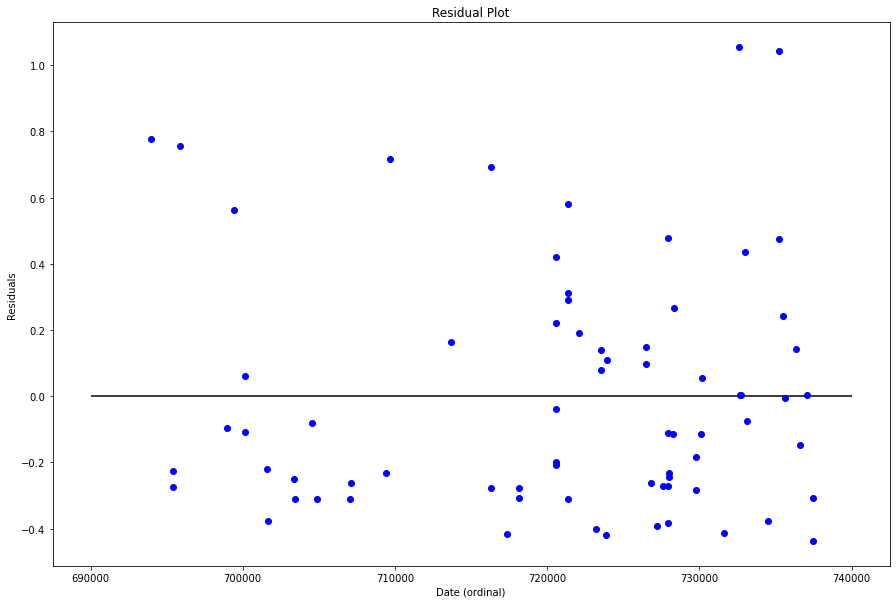

In [61]:
plt.figure(figsize=(15, 10))
#plt.plot(dfNew.waiting, residuals, 'o', color='b')
plt.plot(dfNew.date_ordinal, residuals, 'o', color='b')
plt.hlines(y = 0, xmin=690000, xmax = 740000)
plt.xlabel('Date (ordinal)')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

In [62]:
# sum of residuals should be (close to) 0
print(np.sum(dfNew.meters_above_sealevel - resultsWi.predict(X)))
print(np.sum(residuals)) # the same using 'residuals' variable

-1.98507876802978e-13
-1.98507876802978e-13


In [63]:
# mean of residuals should be (close to) 0
print(np.mean(dfNew.meters_above_sealevel - resultsWi.predict(X)))

-2.7570538444858053e-15


The sum and the mean of residuals are always (close to) 0, but give no indication how close we are to the best line of fit. That is what the Mean Squared Error (MSE) tells us: the smaller, the better line of fit. 

In [64]:
# mean squared error (MSE)
print(np.mean((dfNew.meters_above_sealevel - resultsWi.predict(X))**2))

0.1323477917245452


Since MSE is small, we have a pretty good regression line. Another statistical measure is Residual Sum of Squares (RSS) indicating how much variance in the dependent points is not explained by the regression model.

In [65]:
# residual sum of squares (RSS)
print(np.sum((dfNew.meters_above_sealevel - resultsWi.predict(X))**2))

9.529041004167258


### Conclusion prediction
* the slope of the regression line indicates a small, positive relation between date and storm surge height
* the regression line fits the points well: small MSE.
* the predicted coefficients intercept $\hat{\beta}_0$ and slope $\hat{\beta}_1$ result in realistic storm surge heights (see plot)
* there is a weak real correlation between height and storm surges date. To predict storm surges far more features from different sources are needed. This is an artificial solution to use the Least Squares method to fit a linear regression model for educational purposes. 